# random forest 변수 중요도 확인

- 결측치 제거 및 라벨 인코딩만 수행된 데이터를 활용
- random forest를 통해, 선정된 변수들만 활용해 여러 모델들에서 검증해본다.
- SHAP (SHapley Additive exPlanations)를 통해 변수중요도 산출


random forest hyper parameter는 어떻게 산정할것인지

참고

- 모델 : https://partrita.github.io/posts/random-forest-python/
- 변수중요도 :  https://todayisbetterthanyesterday.tistory.com/56
- shap : https://todayisbetterthanyesterday.tistory.com/57


In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
from glob import glob
import sys

In [2]:
#시각화 패키지들
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
from matplotlib import font_manager, rc
font_path = "C:/Windows/Fonts/NGULIM.TTF"
font = font_manager.FontProperties(fname=font_path).get_name()
rc('font', family=font)
from statsmodels.graphics.mosaicplot import mosaic
plt.style.use("ggplot")

import shap
import skimage


In [3]:
from sklearn.ensemble import RandomForestClassifier

In [17]:
#기초 전처리 데이터 출력
x_train = pd.read_excel("../data/cip_preprocess.xlsx")
x_test = pd.read_excel("../data/cip_preprocess_test.xlsx")

y_train = pd.read_excel("../data/cip_preprocess_y.xlsx")
y_test = pd.read_excel("../data/cip_preprocess_y_test.xlsx")

In [18]:
x_train[['sex','mc','Qsofa','bed','Foley',
   'Hsp-acq','Nursing','3m-Ab','3m-Adm','1y-UTI','PPIantacid',
   'CV','CRF','total malig','NR','Leukopenia','DM','HTN']] =x_train[['sex','mc','Qsofa','bed','Foley',
   'Hsp-acq','Nursing','3m-Ab','3m-Adm','1y-UTI','PPIantacid',
   'CV','CRF','total malig','NR','Leukopenia','DM','HTN']].astype('category') 

In [19]:
x_test[['sex','mc','Qsofa','bed','Foley',
   'Hsp-acq','Nursing','3m-Ab','3m-Adm','1y-UTI','PPIantacid',
   'CV','CRF','total malig','NR','Leukopenia','DM','HTN']] =x_test[['sex','mc','Qsofa','bed','Foley',
   'Hsp-acq','Nursing','3m-Ab','3m-Adm','1y-UTI','PPIantacid',
   'CV','CRF','total malig','NR','Leukopenia','DM','HTN']].astype('category') 

In [20]:
x_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 374 entries, 0 to 373
Data columns (total 38 columns):
 #   Column       Non-Null Count  Dtype   
---  ------       --------------  -----   
 0   sex          374 non-null    category
 1   Age          374 non-null    int64   
 2   mc           374 non-null    category
 3   iSBP         374 non-null    int64   
 4   iDBP         374 non-null    int64   
 5   iPR          374 non-null    int64   
 6   iRR          374 non-null    int64   
 7   iBT          374 non-null    float64 
 8   iSpO         374 non-null    int64   
 9   Qsofa        374 non-null    category
 10  bed          374 non-null    category
 11  Foley        374 non-null    category
 12  Hsp-acq      374 non-null    category
 13  Nursing      374 non-null    category
 14  3m-Ab        374 non-null    category
 15  3m-Adm       374 non-null    category
 16  1y-UTI       374 non-null    category
 17  PPIantacid   374 non-null    category
 18  DM           374 non-null    c

In [21]:
x_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 94 entries, 0 to 93
Data columns (total 38 columns):
 #   Column       Non-Null Count  Dtype   
---  ------       --------------  -----   
 0   sex          94 non-null     category
 1   Age          94 non-null     int64   
 2   mc           94 non-null     category
 3   iSBP         94 non-null     int64   
 4   iDBP         94 non-null     int64   
 5   iPR          94 non-null     int64   
 6   iRR          94 non-null     int64   
 7   iBT          94 non-null     float64 
 8   iSpO         94 non-null     int64   
 9   Qsofa        94 non-null     category
 10  bed          94 non-null     category
 11  Foley        94 non-null     category
 12  Hsp-acq      94 non-null     category
 13  Nursing      94 non-null     category
 14  3m-Ab        94 non-null     category
 15  3m-Adm       94 non-null     category
 16  1y-UTI       94 non-null     category
 17  PPIantacid   94 non-null     category
 18  DM           94 non-null     cat

In [29]:
y_train[['CIP']]

,CIP
0,1
1,0
2,0
3,0
4,0
...,...
369,1
370,1
371,1
372,1


- Random forest parameter (default)
    - n_estimatorsint : 100 (tree 수)
    - criterion : gini
    - bootstrap : true
    - max depth : none
    - min_sample_split : 2 (The minimum number of samples required to split an internal node)
    - min_samples_leaf : 1 (The minimum number of samples required to be at a leaf node)
    - max_features : sqrt (The number of features to consider when looking for the best split) ( sqrt(n_features))
    - max_leaf_nodes : None (Grow trees with max_leaf_nodes in best-first fashion)
    - min_impurity_decrease : 0.0 

In [31]:
rf = RandomForestClassifier(n_estimators=100, oob_score=True, random_state=1234)
# out-of-bag score은 예측이 얼마나 정확한가에 대한 추정을 수치로 나타낸 것입니다.
rf.fit(x_train, y_train['CIP'])

RandomForestClassifier(oob_score=True, random_state=1234)

In [32]:
from sklearn.metrics import accuracy_score

predicted = rf.predict(x_test)
accuracy = accuracy_score(y_test, predicted)

print(f'Out-of-bag score estimate: {rf.oob_score_:.3}')
print(f'Mean accuracy score: {accuracy:.3}')

Out-of-bag score estimate: 0.66
Mean accuracy score: 0.67


<AxesSubplot:>

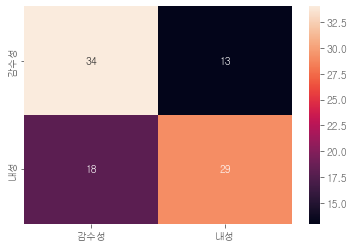

In [33]:
from sklearn.metrics import confusion_matrix

cm = pd.DataFrame(confusion_matrix(y_test, predicted), columns=['감수성','내성'], index=['감수성','내성'])
sns.heatmap(cm, annot=True)

결과, 감수성, 내성 모두 일정한 비율로 못맞추고 있는 상태.

# 변수 중요도



-  Weight : 변수 별 데이터를 분리하는데 쓰인 횟수 
-  Cover : 해당 변수로 분리된 데이터의 수
-  Gain : Feature을 사용했을 때 줄어드는 평균적인 training loss

3가지 방법을 통해 중요도를 나타낼 수 있다.

단점

1. 3가지 방법이 서로 다른 순위의 수치로 나타낸다면, 중요도를 파악하기 어렵다.
2. Positive or Negative 영향을 파악할 수 없다. (domain knowledge를 요구한다.)
3. Ensemble 모델에서 consitency가 보장되지 못한다. (특정 변수가 중요하다 판단하여 모델을 수정했는데, 오히려 중요도가 떨어질 수 있다.)


https://woolulu.tistory.com/28

# shap value

- shap value는 실제값과 예측값 사이의 차이를 이용해 중요도를 파악하는 방법
- 해당 변수의 값을 포함, 미포함 (수정) 의 차이를 구한다.

In [56]:
import shap
import skimage
explainer = shap.TreeExplainer(rf) # Tree model Shap Value 확인 객체 지정
shap_values = explainer.shap_values(x_train) # Shap Values 계산

In [67]:
shap_values[1]

array([[ 1.41610887e-02,  1.73356852e-03,  7.94001222e-03, ...,
         1.15729717e-02,  9.91289500e-03, -1.35849748e-03],
       [ 1.55728783e-03, -5.04882472e-04, -1.77782801e-03, ...,
        -3.89535658e-03, -1.21286839e-02, -1.22846315e-02],
       [-1.99611020e-03,  2.89627853e-04, -4.06696230e-04, ...,
        -6.21714991e-03, -2.10284729e-03, -2.78091187e-02],
       ...,
       [ 7.97399977e-03, -3.54590102e-04,  3.42424942e-03, ...,
         1.29069876e-02,  1.23172919e-02,  2.25047015e-02],
       [-2.61732316e-03,  5.95209324e-03,  5.13265899e-04, ...,
         1.72141579e-02,  1.19420843e-02, -8.08016208e-03],
       [-2.36935852e-03, -8.22325623e-03, -4.76666182e-05, ...,
        -4.92516378e-03, -1.22913978e-02, -3.95439782e-03]])

In [78]:
shap.initjs() # javascript 초기화 (graph 초기화)
#shap.force_plot(explainer.expected_value[0], shap_values[0], x_train)

In [71]:
explainer.expected_value[0]

0.5035561497326203

In [74]:
# 전체 검증 데이터 셋에 대해서 적용
#shap.force_plot(explainer.expected_value[0], shap_values[0], x_train) 

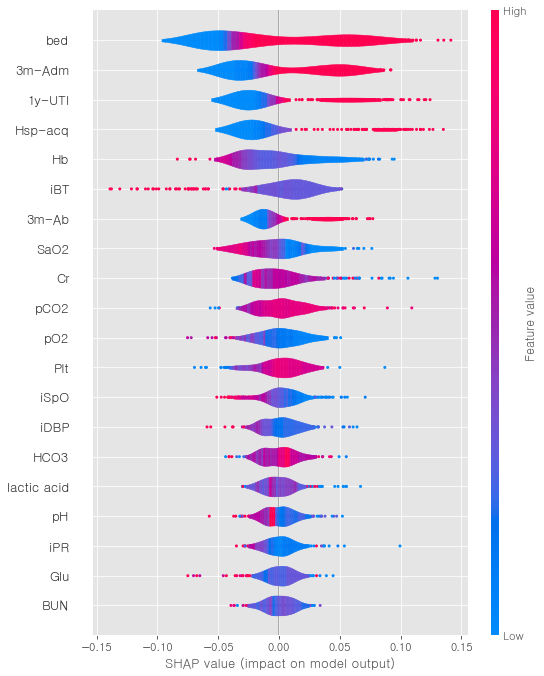

In [87]:
shap.summary_plot(shap_values[1], x_train,plot_type='violin')

내성을 양의 방향으로 Shap summary plot을 나타냈다.

결과, 총 20개의 유의한 변수를 추출했다.

순서를 나타내면.

- category : bed, 3m-Adm, 1y-UTI, Hsp-acq, 3m-Ab
- numeric : Hb, iBT, SaO2, Cr, pCO2, pO2, Plt, iSpO,iDBP,HCO3, lactic acid, pH, iPR, Glu, BUN


# 변수 선택 및 분류

- logistic regression
- svm (종류?)
- random forest

In [88]:
#기초 전처리 데이터 출력
x_train_rftree = x_train.copy()
x_test_rftree = x_test.copy()

In [92]:
x_train_rftree=x_train_rftree[[ 'bed', '3m-Adm', '1y-UTI', 'Hsp-acq', '3m-Ab','Hb', 'iBT', 'SaO2', 'Cr', 'pCO2', 'pO2', 'Plt', 'iSpO','iDBP','HCO3', 'lactic acid', 'pH', 'iPR', 'Glu', 'BUN']]

In [93]:
x_test_rftree=x_test_rftree[[ 'bed', '3m-Adm', '1y-UTI', 'Hsp-acq', '3m-Ab','Hb', 'iBT', 'SaO2', 'Cr', 'pCO2', 'pO2', 'Plt', 'iSpO','iDBP','HCO3', 'lactic acid', 'pH', 'iPR', 'Glu', 'BUN']]

## logistic regression

## svm

## random forest

In [96]:
rf2 = RandomForestClassifier(n_estimators=100, oob_score=True, random_state=1234)
# out-of-bag score은 예측이 얼마나 정확한가에 대한 추정을 수치로 나타낸 것입니다.
rf2.fit(x_train_rftree, y_train['CIP'])

RandomForestClassifier(oob_score=True, random_state=1234)

In [97]:
from sklearn.metrics import accuracy_score

predicted = rf2.predict(x_test_rftree)
accuracy = accuracy_score(y_test, predicted)

print(f'Out-of-bag score estimate: {rf2.oob_score_:.3}')
print(f'Mean accuracy score: {accuracy:.3}')

Out-of-bag score estimate: 0.711
Mean accuracy score: 0.628


변수를 축약하여, 오히려 accuracy가 떨어졌다.